In [10]:
import os
os.environ["PYSPARK_SUBMIT_ARGS"] = "--packages mysql:mysql-connector-java:8.0.22 pyspark-shell"

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from bs4 import BeautifulSoup
import requests
import certifi
import json 
import pandas as pd
base_url = 'http\\://localhost\\:8080/'
covid_all=os.path.join(base_url,'/api/covid/usa/')
from bs4 import BeautifulSoup
import requests
from pyspark.sql.functions import udf
from pyspark.sql.types import DateType,StringType
from datetime import datetime


spark = SparkSession.builder.appName('Extract')\
                            .config("spark.ui.port", "4070")\
                            .getOrCreate()

r = requests.get('http://covid:8080/api/covid/world/countries/USA', auth=('admin', 'admin'))
response = r.json()

covid_monthly = pd.DataFrame.from_dict(response)

covid_monthly = covid_monthly.sort_values(by=['year', 'month'])

r = requests.get('http://covid:8080/api/unemploymentrate/race', auth=('admin', 'admin'))
response = r.json()
# otherPeopleRDD = spark.sparkContext.parallelize(response)
# otherPeople = spark.read.json(otherPeopleRDD)
# otherPeople.show()
park_df = pd.DataFrame.from_dict(response)

#park_df['time'] = pd.to_datetime(park_df['submissionDate'], format='yyyy-mm-dd HH:MM:SS.ss')#'%d%b%Y:%H:%M:%S.%f')
#park_df['time'] = pd.to_datetime(park_df['year'].astype(str)  + park_df['month'], format='%Y%B')
#combine_lambda = lambda x: datetime.date(int(x.year), int(x.month), 1)
af_df = park_df[(park_df['variableName']=='african american') & (park_df['year']>2019)]\
.sort_values(by=['year', 'month'])

af_df['time'] = pd.to_datetime(af_df[['year', 'month']].assign(day=1))
date_sub = af_df['time'].dt.date.tolist()
af_df = af_df['unemployedRate'].tolist()
white_df = park_df[(park_df.variableName=='white') & (park_df['year']>2019)]\
.sort_values(by=['year', 'month'])['unemployedRate']\
.tolist()
hisp_df = park_df[(park_df.variableName=='hispanic') & (park_df['year']>2019)]\
.sort_values(by=['year', 'month'])['unemployedRate']\
.tolist()
asian = park_df[(park_df.variableName=='asian') & (park_df['year']>2019)]\
.sort_values(by=['year', 'month'])['unemployedRate']\
.tolist()


# # def build_date(m,y):
# #     return datetime.now().replace(day=1, month=int(m),year=int(y))
# # date_udf =udf(lambda m, y:build_date(m,y) , DateType())      
# combine_lambda = lambda x: '{}-{}'.format(x.year, x.month)
# # covid_new = covid_monthly.withColumn('submission_date',date_udf(covid_monthly.month,covid_monthly.year))\
# # .select('submission_date','monthlyNewCases').toPandas()
covid_deaths = covid_monthly['monthlyNewDeaths'].tolist()[:len(date_sub)]


[3.4, 4.1, 13.8, 12.1, 10.2, 9.4, 7.5, 6.8, 5.7, 5.7, 5.9, 6.2, 5.9, 5.5]
[4.8, 6.3, 18.5, 17.2, 14.5, 13.0, 10.5, 10.0, 8.5, 8.3, 9.2, 9.4, 9.0, 8.2]


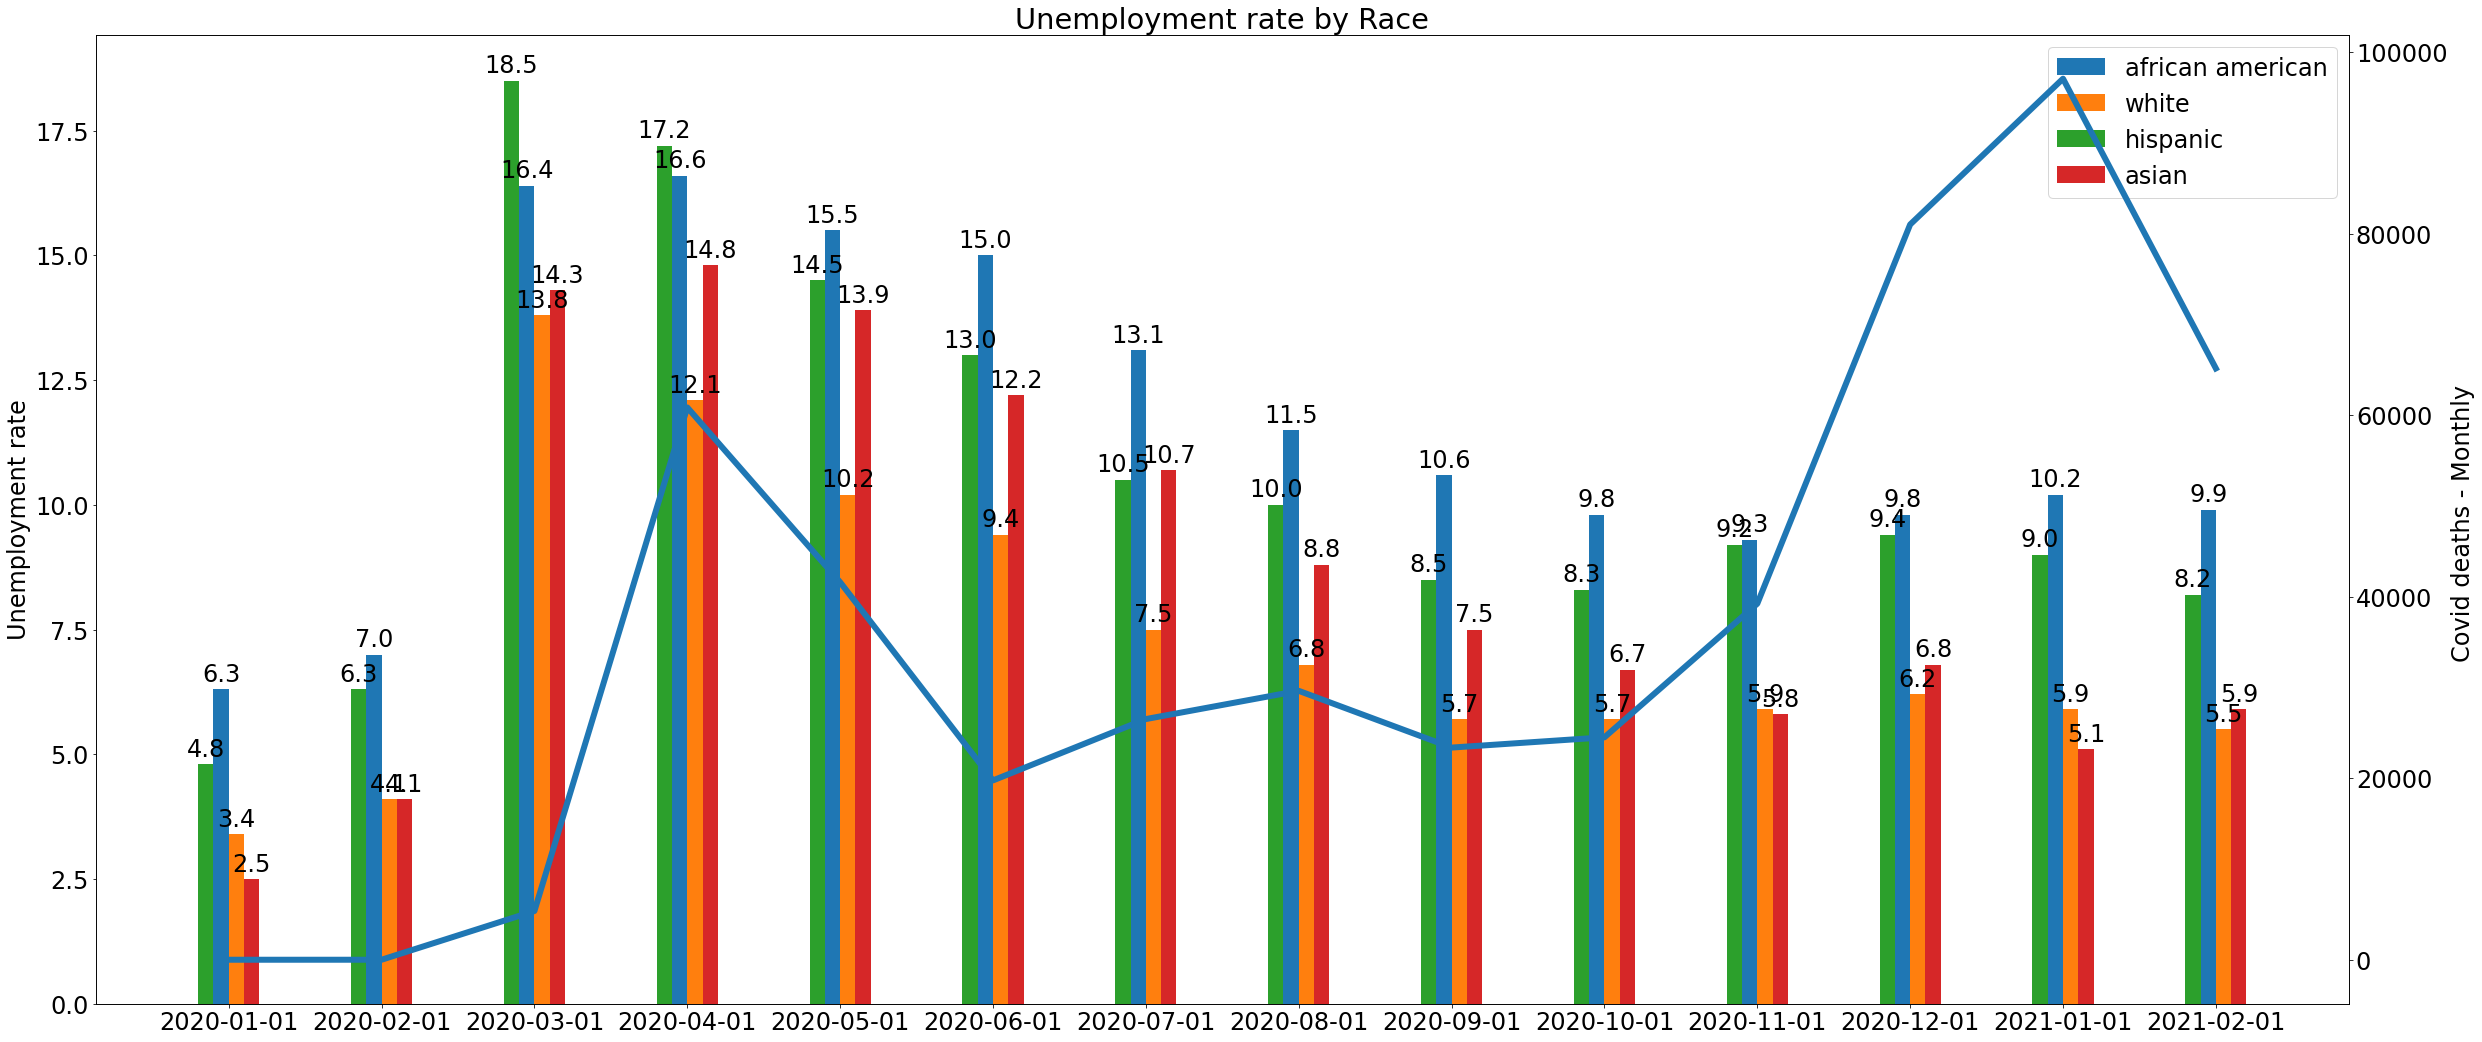

In [11]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [35, 15]
plt.rcParams.update({'font.size': 24})
fig ,ax = plt.subplots()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
def assign_ax(ax, x, labels, ylabel, title):
    # # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

labels = date_sub

x = np.arange(len(labels))  # the label locations
width = 0.20  # the width of the bars

rects1 = ax.bar(x -0.05, af_df, 0.10, label='african american')
rects2 = ax.bar(x + 0.05, white_df, .10, label='white')
rects3 = ax.bar(x - 0.15, hisp_df, .10, label='hispanic')
rects4 = ax.bar(x + 0.15, asian, .10, label='asian')

assign_ax(ax, x, labels, 'Unemployment rate', 'Unemployment rate by Race')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

ax2 = ax.twinx()
ax2.set_ylabel('Covid deaths - Monthly ')

ax2.plot(covid_deaths,linewidth=6)

fig.tight_layout()

plt.show()

In [23]:
from pyspark.sql.types import StringType
r = requests.get('http://covid:8080/api/unemploymentrate/industry', auth=('admin', 'admin'))
response = r.json()
jsonrdd = spark.sparkContext.parallelize(response)
park_df = spark.read.json(jsonrdd)
park_df = park_df.filter(park_df.year>2019).sort("year","month")
prof_bui_df = park_df.filter(park_df.variableName=='professional business')

prof_bui_df_pandas = prof_bui_df.select('unemployedRate').toPandas()['unemployedRate'].tolist()
date_udf =udf(lambda m, y:"{}-{}".format(m,y) , StringType())    
date_sub = prof_bui_df.withColumn('date',date_udf(prof_bui_df.month,prof_bui_df.year))\
                      .toPandas()['date']\
                      .tolist()

edu_health_df = park_df.filter(park_df.variableName=='education health care')\
                        .select('unemployedRate')\
                        .toPandas()['unemployedRate']\
                        .tolist()

manufacture_df = park_df.filter(park_df.variableName=='manufacturing')\
                        .select('unemployedRate')\
                        .toPandas()['unemployedRate']\
                        .tolist()

agriculture_df = park_df.filter(park_df.variableName=='agriculture related')\
                        .select('unemployedRate')\
                        .toPandas()['unemployedRate']\
                        .tolist()

construction = park_df.filter(park_df.variableName=='construction')\
                      .select('unemployedRate')\
                      .toPandas()['unemployedRate']\
                      .tolist()

transportation = park_df.filter(park_df.variableName=='transportation and utilities')\
                        .select('unemployedRate')\
                        .toPandas()['unemployedRate']\
                        .tolist()

leisure = park_df.filter(park_df.variableName=='leisure hospitality')\
                .select('unemployedRate')\
                .toPandas()['unemployedRate']\
                .tolist()
# def build_date(m,y):
#     return datetime.now().replace(day=1, month=int(m),year=int(y))
# date_udf =udf(lambda m, y:build_date(m,y) , DateType())        
covid_new = covid_monthly['monthlyNewCases']\
                         .tolist()[:len(date_sub)]

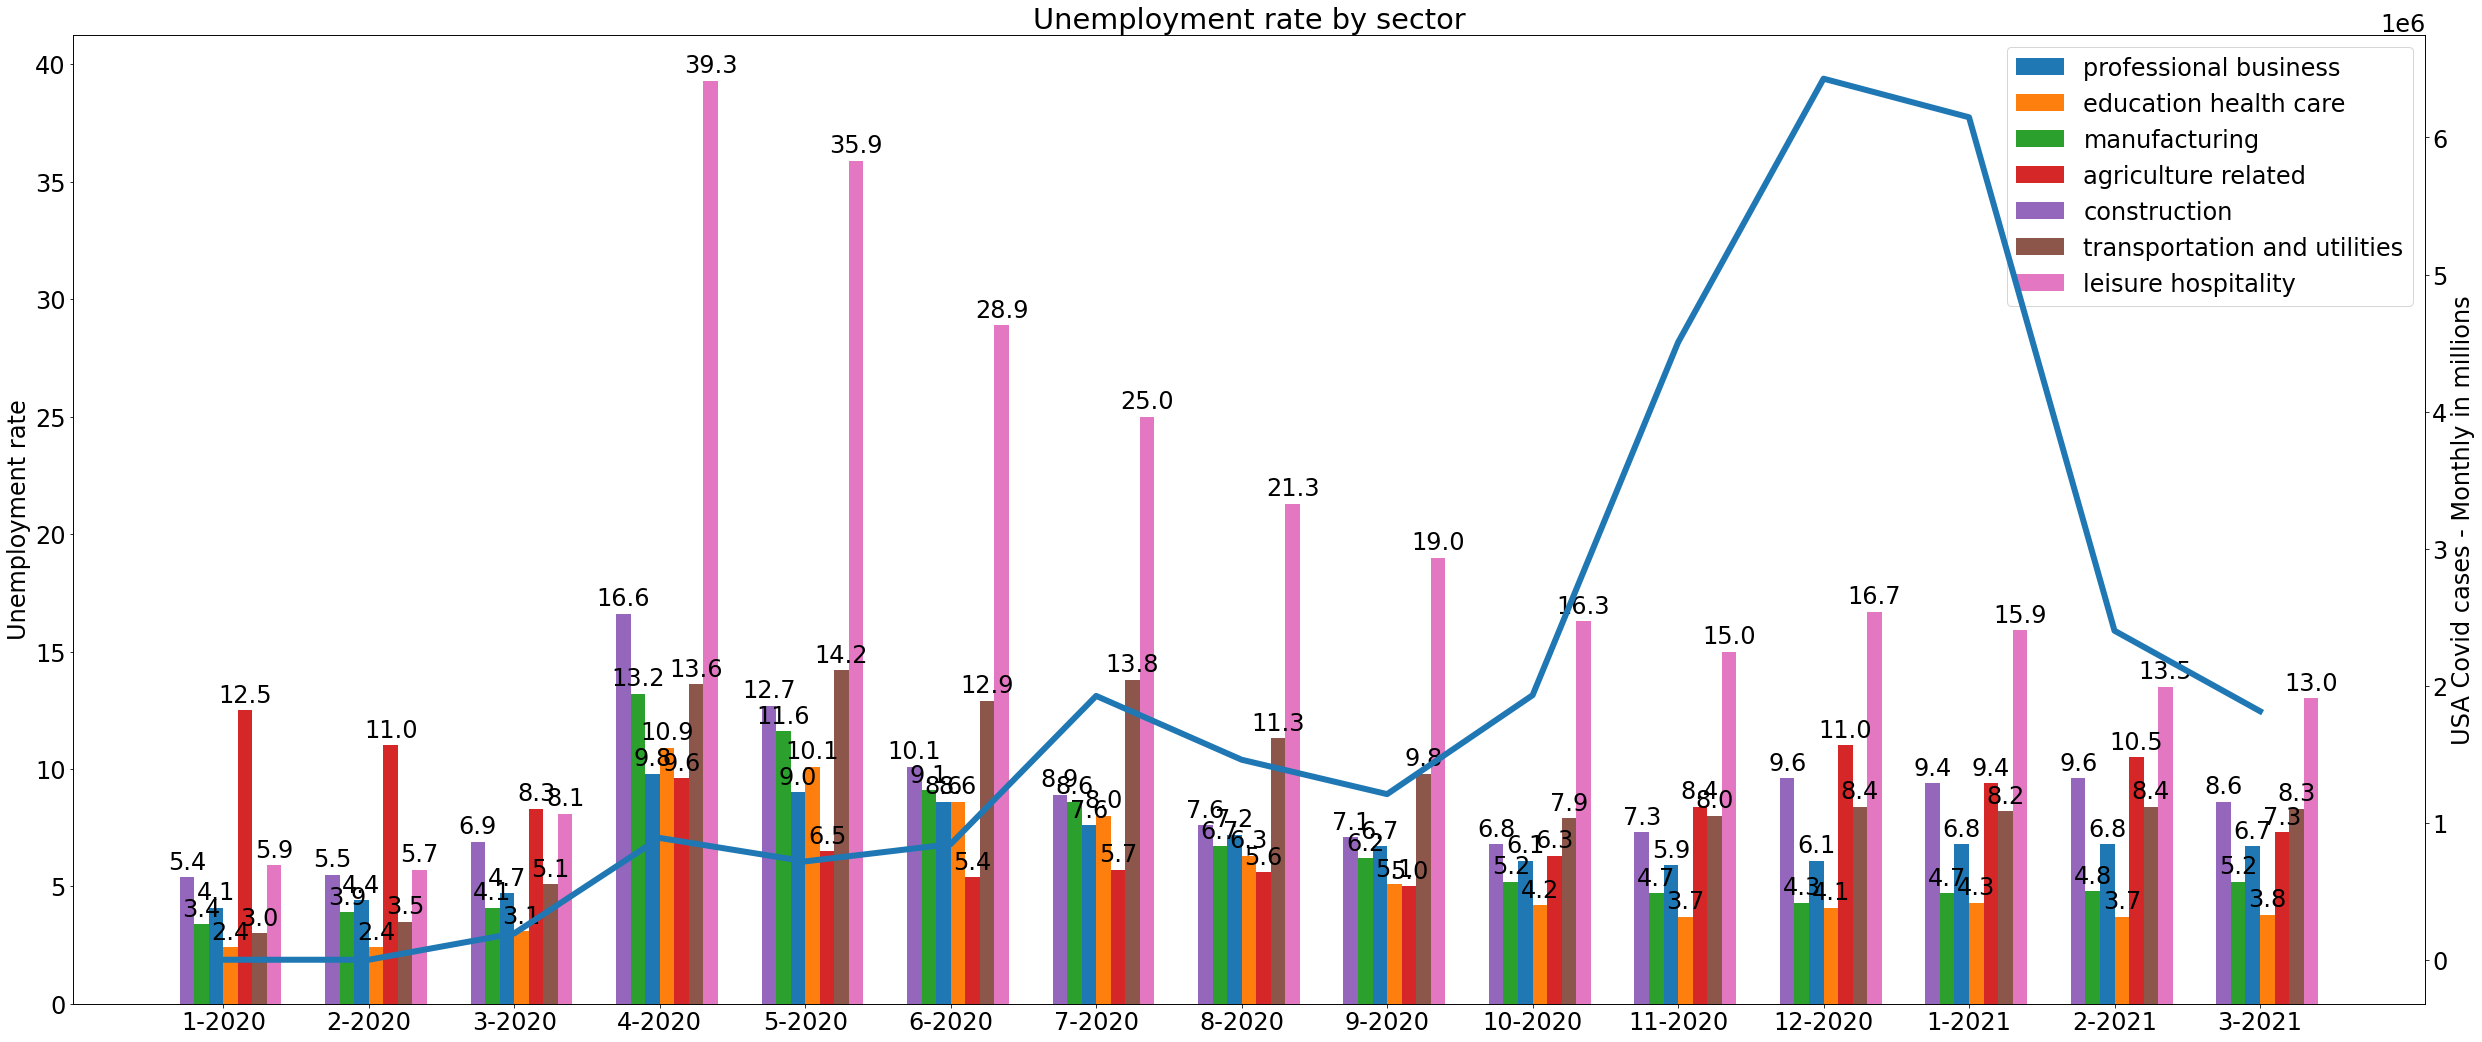

In [22]:
labels = date_sub
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
fig ,ax = plt.subplots()

rects1 = ax.bar(x -0.05, prof_bui_df_pandas, 0.10, label='professional business')
rects2 = ax.bar(x + 0.05, edu_health_df, .10, label='education health care')
rects3 = ax.bar(x - 0.15, manufacture_df, .10, label='manufacturing')
rects4 = ax.bar(x + 0.15, agriculture_df, .10, label='agriculture related')
rects5 = ax.bar(x - 0.25, construction, .10, label='construction')
rects6 = ax.bar(x + 0.25, transportation, .10, label='transportation and utilities')
rects7 = ax.bar(x + 0.35, leisure, 0.10, label='leisure hospitality')

# # Add some text for labels, title and custom x-axis tick labels, etc.
assign_ax(ax, x, labels, 'Unemployment rate', 'Unemployment rate by sector')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)
autolabel(rects5)
autolabel(rects6)
autolabel(rects7)


ax2 = ax.twinx()
ax2.set_ylabel('USA Covid cases - Monthly in millions')

ax2.plot( covid_new,linewidth=6)

fig.tight_layout()

plt.show()

In [46]:
from pyspark.sql.types import StringType
r = requests.get('http://covid:8080/api/covid/world/countries?countries=OWID_WRL,USA,IND,BRA,ITA', auth=('admin', 'admin'))
response = r.json()
jsonrdd = spark.sparkContext.parallelize(response)
park_df = spark.read.json(jsonrdd)
park_df = park_df.sort("year","month")

prof_world = park_df.filter(park_df.country=='OWID_WRL')

world_df = prof_world.select('totalCases').toPandas()['totalCases'].tolist()[1:]

date_udf =udf(lambda m, y:"{}-{}".format(m,y) , StringType())    
date_sub = prof_world.withColumn('date',date_udf(prof_world.month,prof_world.year))\
                      .toPandas()['date']\
                      .tolist()[1:]


usa_df = park_df.filter(park_df.country=='USA')\
                        .select('totalCases')\
                        .toPandas()['totalCases']\
                        .tolist()[1:]

ind_df = park_df.filter(park_df.country=='IND')\
                        .select('totalCases')\
                        .toPandas()['totalCases']\
                        .tolist()[1:]

bra_df = park_df.filter(park_df.country=='BRA')\
                        .select('totalCases')\
                        .toPandas()['totalCases']\
                        .tolist()

ita_df = park_df.filter(park_df.country=='ITA')\
                      .select('totalCases')\
                      .toPandas()['totalCases']\
                      .tolist()[1:]


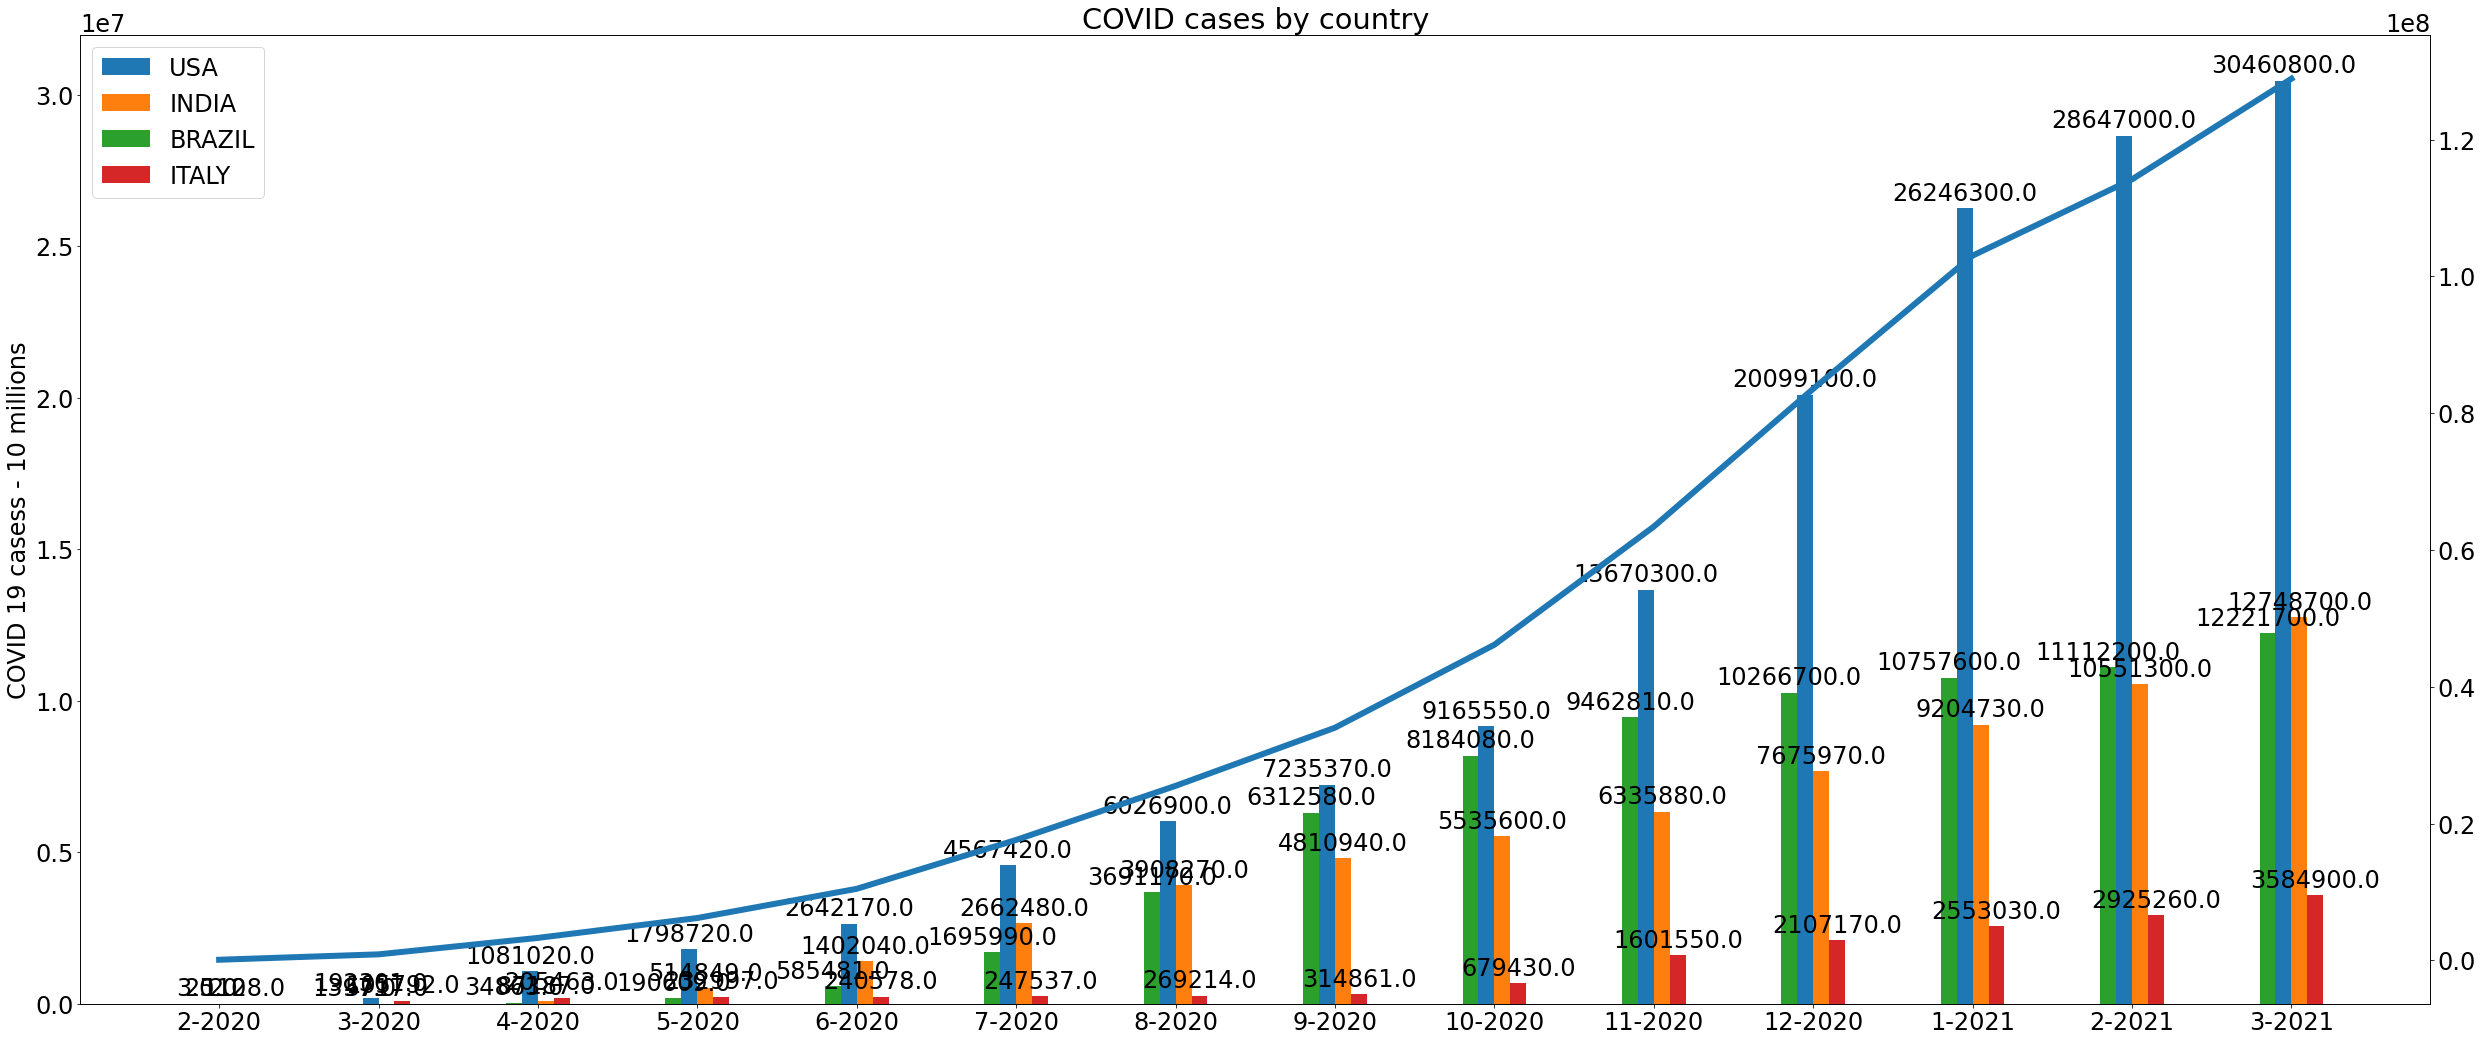

In [48]:
labels = date_sub
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
fig ,ax = plt.subplots()


rects1 = ax.bar(x -0.05, usa_df, .10, label='USA')
rects2 = ax.bar(x + 0.05, bra_df, .10, label='INDIA')
rects3 = ax.bar(x - 0.15, ind_df, .10, label='BRAZIL')
rects4 = ax.bar(x + 0.15, ita_df, .10, label='ITALY')

# rects7 = ax.bar(x + 0.35, leisure, 0.10, label='leisure hospitality')

# # Add some text for labels, title and custom x-axis tick labels, etc.
assign_ax(ax, x, labels, 'COVID 19 casess - 10 millions', 'COVID cases by country')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)
# autolabel(rects5)
# autolabel(rects6)
# autolabel(rects7)


ax2 = ax.twinx()

# Plot the relative temperature in red
ax2.plot(world_df,label="WORLD",linewidth=6)
# ax2.plot(ind_df,label="INDIA",linewidth=6)
# ax2.plot(bra_df,label="BRAZIL",linewidth=6)
# ax2.plot(ita_df,label="ITALY",linewidth=6)
fig.tight_layout()
#plt.legend()


plt.show()

In [72]:
from pyspark.sql.types import StringType
import pyspark.sql.functions as F
r = requests.get('http://covid:8080/api/covid/usa/' , auth=('admin', 'admin'))
response = r.json()
jsonrdd = spark.sparkContext.parallelize(response)
park_df = spark.read.json(jsonrdd)
park_df1 = park_df.groupBy('state')\
                .agg(F.max('totalCases').alias('max_cases'),F.max('totalDeaths').alias('max_Deaths'))\
                .sort("max_cases","max_deaths")\
                .show(11)#.withColumn("per100000",park_df.totalCases/park_df.sort("year","month")

park_df = park_df.groupBy('state')\
                .agg(F.max('totalCases').alias('max_cases'),F.max('totalDeaths').alias('max_Deaths'))\
                .sort(F.col('max_cases').desc(),F.col('max_deaths').desc())\
                .show(10)

r = requests.get('http://covid:8080/api/unemploymentrate/state' , auth=('admin', 'admin'))
response = r.json()
jsonrdd = spark.sparkContext.parallelize(response)
park_df = spark.read.json(jsonrdd)
park_df1 = park_df.groupBy('variableName')\
                .agg(F.max('unemployedRate').alias('max_rate'))\
                .sort(F.col('max_rate').desc())\
                .show(10)
park_df2 = park_df.groupBy('variableName')\
                .agg(F.max('unemployedRate').alias('max_rate'))\
                .sort(F.col('max_rate'))\
                .show(10)
park_df= park_df.filter(park_df.year==2019)
park_df1 = park_df.groupBy('variableName')\
                .agg(F.max('unemployedRate').alias('max_rate'))\
                .sort(F.col('max_rate').desc())\
                .show(10)
park_df2 = park_df.groupBy('variableName')\
                .agg(F.max('unemployedRate').alias('max_rate'))\
                .sort(F.col('max_rate'))\
                .show(10)


+-----+---------+----------+
|state|max_cases|max_Deaths|
+-----+---------+----------+
|   PW|      0.0|       0.0|
|  FSM|      1.0|       0.0|
|  RMI|      4.0|       0.0|
|   AS|      4.0|       0.0|
|   MP|    159.0|       2.0|
|   VI|   2907.0|      26.0|
|   GU|   7810.0|     134.0|
|   VT|  19523.0|     227.0|
|   HI|  28734.0|     460.0|
|   DC|  44513.0|    1064.0|
|   ME|  50788.0|     743.0|
+-----+---------+----------+
only showing top 11 rows

+-----+---------+----------+
|state|max_cases|max_Deaths|
+-----+---------+----------+
|   CA|3568430.0|   57936.0|
|   TX|2783440.0|   47404.0|
|   FL|2019500.0|   33425.0|
|   IL|1244580.0|   23579.0|
|   GA|1059550.0|   19055.0|
|   NY|1026170.0|   18784.0|
|   PA|1024860.0|   25093.0|
|   OH|1017570.0|   18611.0|
|   NC| 914132.0|   12112.0|
|   NJ| 908816.0|   24561.0|
+-----+---------+----------+
only showing top 10 rows

+------------+--------+
|variableName|max_rate|
+------------+--------+
|          NV|    29.5|
|          

In [81]:
from pyspark.sql.types import StringType
import pyspark.sql.functions as F
r = requests.get('http://covid:8080/api/covid/usa/states?states=NV,MI,CA,HI,NY' , auth=('admin', 'admin'))
response = r.json()
jsonrdd = spark.sparkContext.parallelize(response)
park_df = spark.read.json(jsonrdd)
park_df.show()
world_df = park_df.filter(park_df.year==2020).sort("year","month")#.select('totalCases').toPandas()['totalCases'].tolist()
nv_df=world_df.filter(world_df.state=='NV').select('totalCases').toPandas()['totalCases'].tolist()[:11]
MI_df=world_df.filter(world_df.state=='MI').select('totalCases').toPandas()['totalCases'].tolist()[:11]
ca_df=world_df.filter(world_df.state=='CA').select('totalCases').toPandas()['totalCases'].tolist()[:11]
hi_df=world_df.filter(world_df.state=='HI').select('totalCases').toPandas()['totalCases'].tolist()[:11]
ny_df=world_df.filter(world_df.state=='NY').select('totalCases').toPandas()['totalCases'].tolist()[:11]

# date_udf =udf(lambda m, y:"{}-{}".format(m,y) , StringType())    
# date_sub = prof_world.withColumn('date',date_udf(prof_world.month,prof_world.year))\
#                       .toPandas()['date']\
#                       .tolist()[1:]


r = requests.get('http://covid:8080/api/unemploymentrate/states?states=NV,MI,CA,HI,NY' , auth=('admin', 'admin'))
response = r.json()
jsonrdd = spark.sparkContext.parallelize(response)
park_df = spark.read.json(jsonrdd)
park_2019 =park_df.filter(park_df.year==2019).sort("year","month")#.select("variableName","year","month",'unemployedRate')
park_2020 =park_df.filter(park_df.year==2020).sort("year","month")
date_sub=['1-2019/2020','2-2019/2020','3-2019/2020','4-2019/2020','5-2019/2020','6-2019/2020','7-2019/2020',\
          '8-2019/2020','9-2019/2020','10-2019/2020','11-2019/2020']
nv_df_2019=park_2019.filter(park_2019.variableName=='NV')\
                    .select('unemployedRate')\
                    .toPandas()['unemployedRate']\
                    .tolist()
nv_df_2020=park_2020.filter(park_2020.variableName=='NV')\
                    .select('unemployedRate')\
                    .toPandas()['unemployedRate']\
                    .tolist()
MI_df_2019=park_2019.filter(park_2019.variableName=='MI')\
                    .select('unemployedRate')\
                    .toPandas()['unemployedRate']\
                    .tolist()
MI_df_2020=park_2020.filter(park_2020.variableName=='MI')\
                    .select('unemployedRate')\
                    .toPandas()['unemployedRate']\
                    .tolist()
ca_df_2019=park_2019.filter(park_2019.variableName=='CA')\
                    .select('unemployedRate')\
                    .toPandas()['unemployedRate']\
                    .tolist()
ca_df_2020=park_2020.filter(park_2020.variableName=='CA')\
                    .select('unemployedRate')\
                    .toPandas()['unemployedRate']\
                    .tolist()
hi_df_2019=park_2019.filter(park_2019.variableName=='HI')\
                    .select('unemployedRate')\
                    .toPandas()['unemployedRate']\
                    .tolist()
hi_df_2020=park_2020.filter(park_2020.variableName=='HI')\
                    .select('unemployedRate')\
                    .toPandas()['unemployedRate']\
                    .tolist()
ny_df_2019=park_2019.filter(park_2019.variableName=='NY')\
                    .select('unemployedRate')\
                    .toPandas()['unemployedRate']\
                    .tolist()
ny_df_2020=park_2020.filter(park_2020.variableName=='NY')\
                    .select('unemployedRate')\
                    .toPandas()['unemployedRate']\
                    .tolist()


+-----------+------------+---+-----+---------------+----------------+-----+----------+-----------+----+
|avgNewCases|avgNewDeaths| id|month|monthlyNewCases|monthlyNewDeaths|state|totalCases|totalDeaths|year|
+-----------+------------+---+-----+---------------+----------------+-----+----------+-----------+----+
|        0.3|         0.0|498|    1|            3.0|             0.0|   CA|       3.0|        0.0|2020|
|    32192.5|     493.903|801|    1|       997969.0|         15311.0|   CA| 3243350.0|    40697.0|2021|
|   0.310345|         0.0|861|    2|            9.0|             0.0|   CA|      12.0|        0.0|2020|
|    8293.36|     374.143|508|    2|       232214.0|         10476.0|   CA| 3475560.0|    51979.0|2021|
|    261.903|     5.54839|469|    3|         8119.0|           172.0|   CA|    8131.0|      172.0|2020|
|    2876.97|     192.161|256|    3|        89186.0|          5957.0|   CA| 3568430.0|    57936.0|2021|
|    1359.53|     60.3333|513|    4|        40786.0|          18

['1-2019/2020', '2-2019/2020', '3-2019/2020', '4-2019/2020', '5-2019/2020', '6-2019/2020', '7-2019/2020', '8-2019/2020', '9-2019/2020', '10-2019/2020', '11-2019/2020']
[4.1, 4.1, 4.0, 3.9, 3.9, 3.9, 3.9, 3.8, 3.7, 3.7, 3.6]


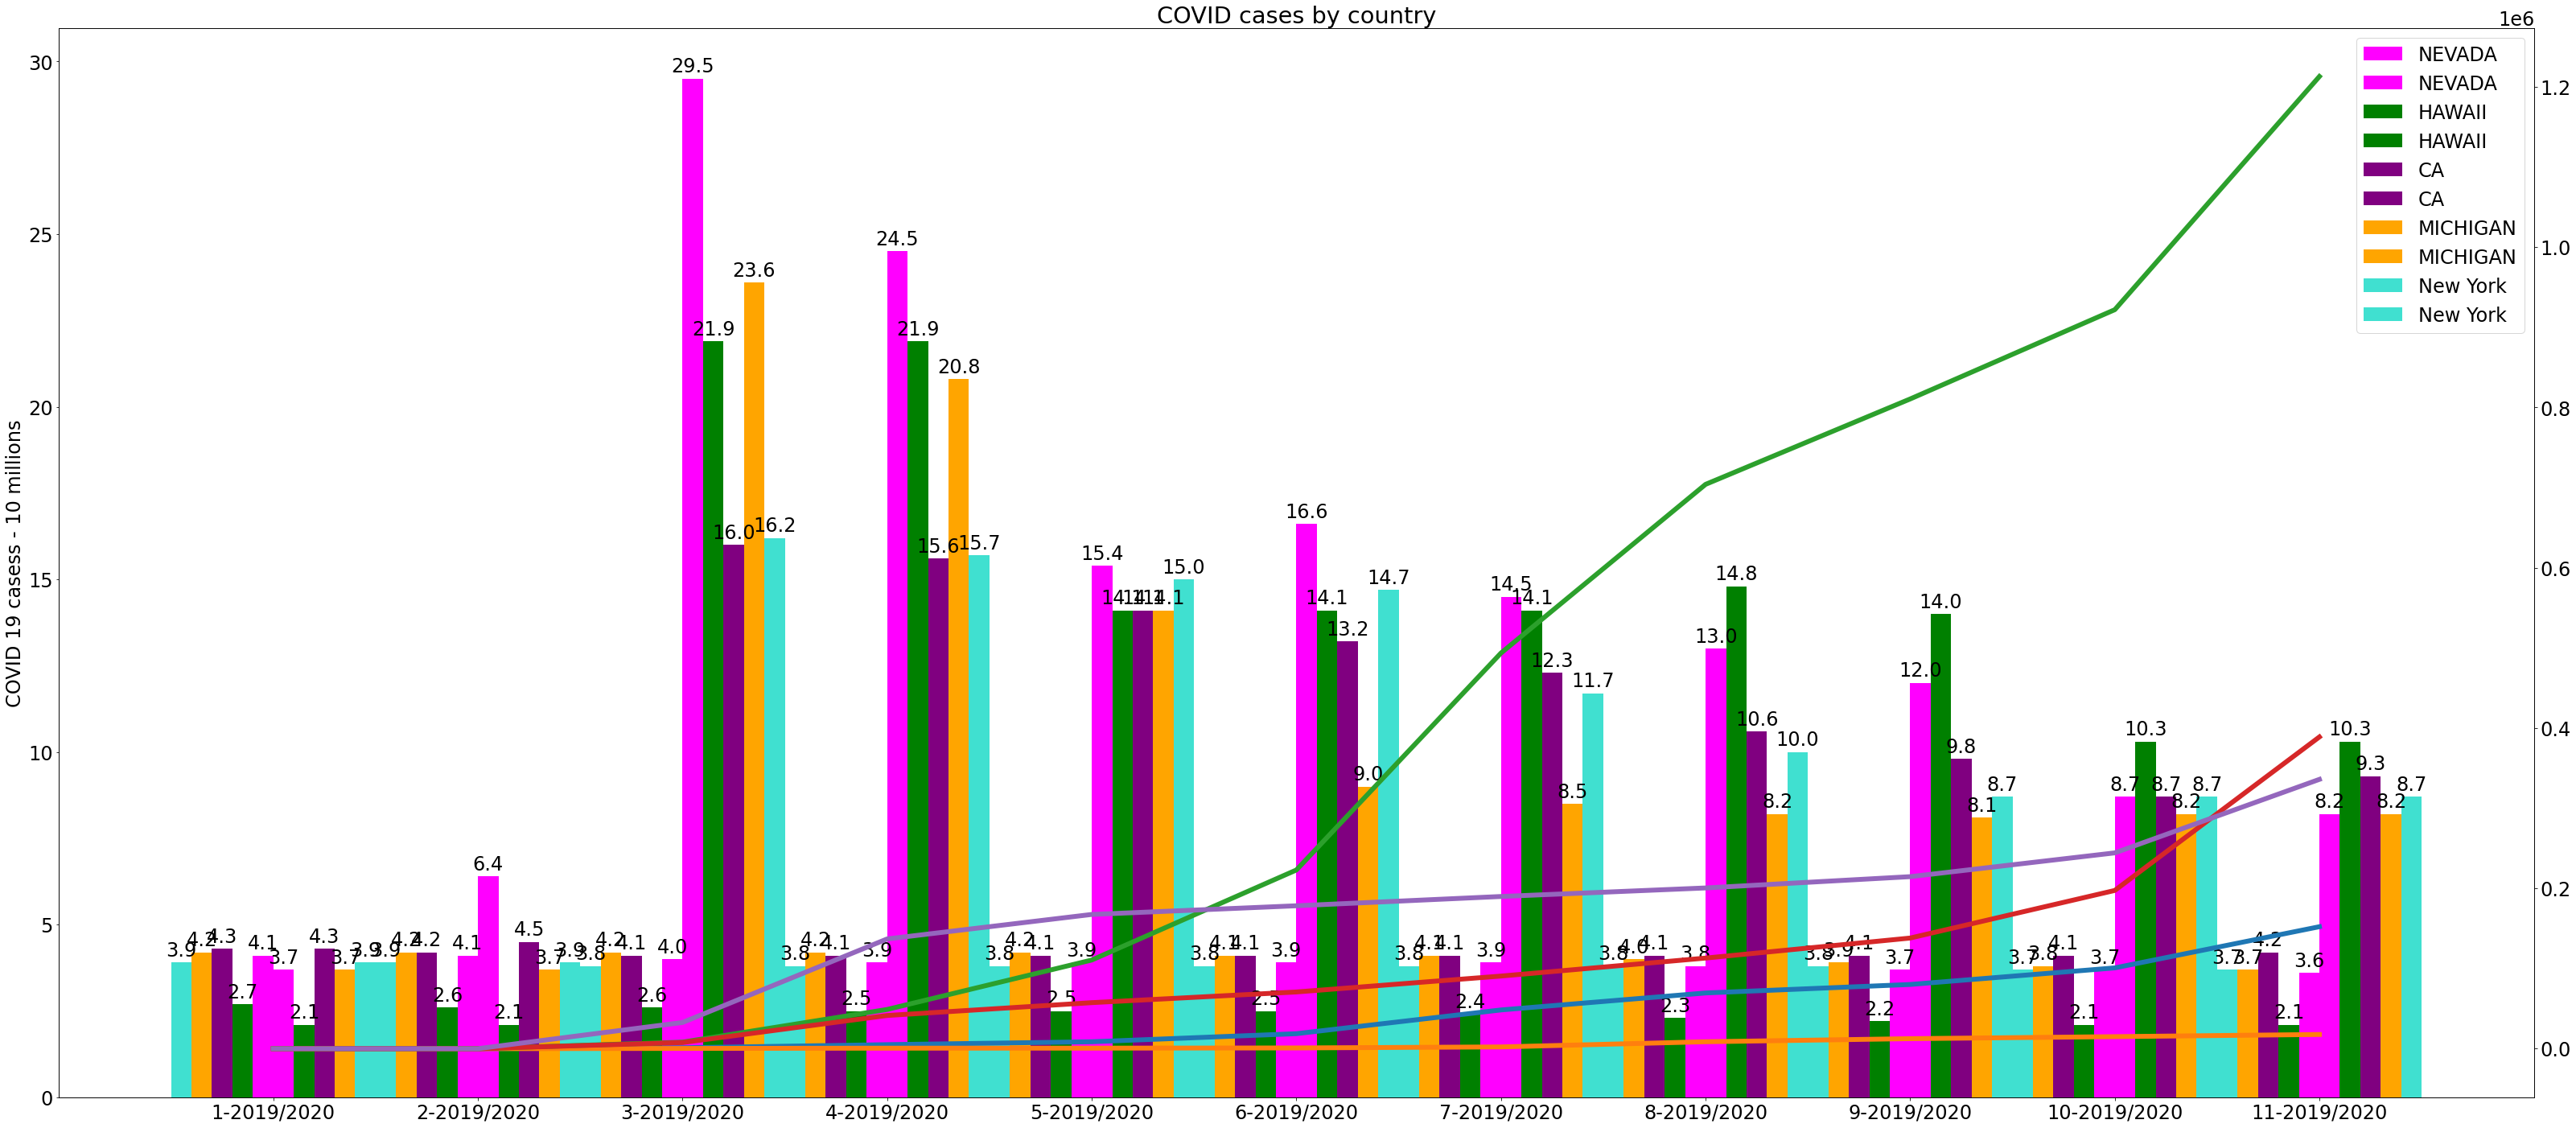

In [85]:
labels = date_sub
plt.rcParams['figure.figsize'] = [45, 20]
plt.rcParams.update({'font.size': 24})
fig ,ax = plt.subplots()
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
#fig ,ax = plt.subplots()
print(date_sub)
print(nv_df_2019)


rects1 = ax.bar(x -0.05, nv_df_2019, .10, label='NEVADA',color='fuchsia')
rects2 = ax.bar(x + 0.05, nv_df_2020, .10, label='NEVADA',color='fuchsia')
rects3 = ax.bar(x - 0.15, hi_df_2019, .10, label='HAWAII',color='green')
rects4 = ax.bar(x + 0.15, hi_df_2020, .10, label='HAWAII',color='green')
rects5 = ax.bar(x - 0.25, ca_df_2019, .10, label='CA',color='purple')
rects6 = ax.bar(x + 0.25, ca_df_2020, .10, label='CA',color='purple')
rects7 = ax.bar(x - 0.35, MI_df_2019, .10, label='MICHIGAN',color='orange')
rects8 = ax.bar(x + 0.35, MI_df_2020, .10, label='MICHIGAN',color='orange')
rects9 = ax.bar(x - 0.45, ny_df_2019, .10, label='New York',color='turquoise')
rects10 = ax.bar(x + 0.45, ny_df_2020, .10, label='New York',color='turquoise')

# rects7 = ax.bar(x + 0.35, leisure, 0.10, label='leisure hospitality')

# # Add some text for labels, title and custom x-axis tick labels, etc.
assign_ax(ax, x, labels, 'COVID 19 casess - 10 millions', 'COVID cases by country')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)
autolabel(rects5)
autolabel(rects6)
autolabel(rects7)
autolabel(rects8)
autolabel(rects9)
autolabel(rects10)


ax2 = ax.twinx()

# Plot the relative temperature in red
ax2.plot(nv_df,label="NEVADA",linewidth=6)
ax2.plot(hi_df,label="HAWAII",linewidth=6)
ax2.plot(ca_df,label="CALIFORNIA",linewidth=6)
ax2.plot(MI_df,label="MICHIGAN",linewidth=6)
ax2.plot(ny_df,label="NEW YORK",linewidth=6)
fig.tight_layout()
#plt.legend()


plt.show()